Before the classifier

In [38]:
import os
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load messages from a folder
def load_messages(folder_path, label, encoding='latin-1'):
    messages = []
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding=encoding) as file:
            message = file.read()
            messages.append((message, label))
    return messages

# Load spam and non-spam messages
spam_folder = 'Spamas'
non_spam_folder = 'Ne spamas'

spam_messages = load_messages(spam_folder, 'spam')
non_spam_messages = load_messages(non_spam_folder, 'non_spam')

# Split messages into training and testing sets
train_ratio = 0.8
train_spam_count = int(train_ratio * len(spam_messages))
train_non_spam_count = int(train_ratio * len(non_spam_messages))

train_messages = spam_messages[:train_spam_count] + non_spam_messages[:train_non_spam_count]
test_messages = spam_messages[train_spam_count:] + non_spam_messages[train_non_spam_count:]

# Preprocess the messages, to be exact, remove punctuation
translator = str.maketrans('', '', string.punctuation)
X_train, y_train = zip(*train_messages) 
X_test, y_test = zip(*test_messages)

# vectorizer is used to convert text to numerical feature vectors
# vocabulary is a dictionary that converts each lexeme (word) to a unique integer ID
vectorizer = CountVectorizer(stop_words='english') # Remove stop words (words that are too common and don't carry much information, eg. 'the', 'a', 'is', etc.)

# Fit the vectorizer to training data and transform it to feature vectors (converting text to numerical feature vectors where each feature the count of lexemes (words) in the message)
# Feauture extraction model is built from the training data 
X_train_counts = vectorizer.fit_transform(X_train)                                           
X_test_counts = vectorizer.transform(X_test)

The classifier itself

In [39]:
import numpy as np

class NaiveBayesClassifier:
    def __init__(self):
        self.prior_prob = {}  # Prior probability of each class
        self.feature_prob = {}  # Conditional probability is a probability of each lexeme given each class meaning that 
        self.classes = []  # List of unique class labels

    def fit(self, X, y):
        # Compute prior probabilities
        self.classes, class_counts = np.unique(y, return_counts=True)
        total_messages = len(y)

        print("Shape of X:", X.shape)

        for cls, count in zip(self.classes, class_counts): # count is the number of messages in the class
            self.prior_prob[cls] = count / total_messages # self.prior_prob[cls] is the prior probability of the class meaning 

        # Compute conditional probabilities for each lexeme
        # difference between conditional probability and prior probability is that prior probability is the probability of each message being in the class, and conditional probability is the probability of each lexeme being in the class
        num_lexemes = X.shape[1]
        for cls in self.classes:
            class_messages = np.array(X)[np.array(y) == cls]
            total_messages_in_class = len(class_messages)
            self.feature_prob[cls] = {}

            for lexeme in range(num_lexemes):
                # Skip iteration if no instances of the class
                if total_messages_in_class == 0:
                    continue
                
                lexeme_counts = np.sum(class_messages[:, lexeme], axis=0, where=(class_messages[:, lexeme] > 0))
                self.feature_prob[cls][lexeme] = (lexeme_counts + 1) / (total_messages_in_class + num_lexemes)

    def predict(self, X, print_results=True):
        predictions = []

        for i, message in enumerate(X):
            class_scores = []
            for cls in self.classes:
                class_score = np.log(self.prior_prob[cls])  # Prior probability of the class
                for lexeme, value in enumerate(message):
                    if value > 0:   # If the any lexeme is present in the message
                        prob_cls = self.feature_prob[cls].get(lexeme, 0)  # get(lexeme, 0) lexeme is the key, 0 is the default value if the key is not found 
                        if prob_cls == 0:
                            if cls == 'non_spam':
                                prob_cls = 0.99
                            else:
                                prob_cls = 0.01
                        class_score += np.log(prob_cls) # class_score is the probability of the message being in the spam/non-spam class given the lexeme
                class_scores.append(class_score) # class_scores is the list of probabilities of each spam/non-spam class given the message

            predicted_class = self.classes[np.argmax(class_scores)]
            predictions.append(predicted_class)

        '''
        if print_results:
            # Print probabilities of each lexeme given each class
            print("Probabilities:")
            for cls in self.classes:
                print(f"P(W|{cls}):")
                for lexeme, prob in self.feature_prob[cls].items():
                    print(f"  Lexeme {lexeme}: {prob}")
                print()

            print("P(S|W) (Spamicity probability):")
            for i, message in enumerate(X):
                spamicity_probs = []
                for lexeme, value in enumerate(message):
                    if value > 0:
                        spamicity_prob = self.feature_prob['spam'].get(lexeme, 0) / \
                                         (self.feature_prob['spam'].get(lexeme, 0) +
                                          self.feature_prob['non_spam'].get(lexeme, 0))
                        spamicity_probs.append(spamicity_prob)
                print(f"Message {i}: {spamicity_probs}")
            print()
        
            # Print N number of analyzed lexemes
            num_lexemes = len(self.feature_prob['spam'])
            #print(f"Number of analyzed lexemes (N): {num_lexemes}")

            # Print classification accuracy
            accuracy = (correct_count / num_messages) * 100
            print(f"Classification Accuracy: {accuracy:.2f}%")
        '''
        return predictions


After the classifier

Dependency of false positive and true negative number on number N of analyzed lexemes (N = 8, 16, 32, 64)

Shape of X: (3461, 81564)
Shape of X: (3461, 8)
Shape of X: (3461, 16)
Shape of X: (3461, 32)
Shape of X: (3461, 64)


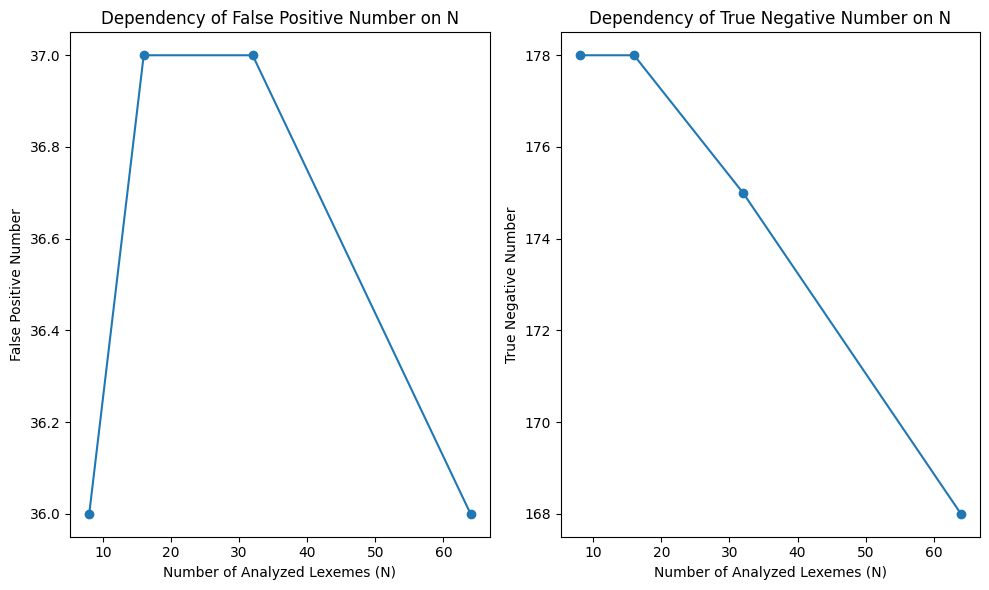

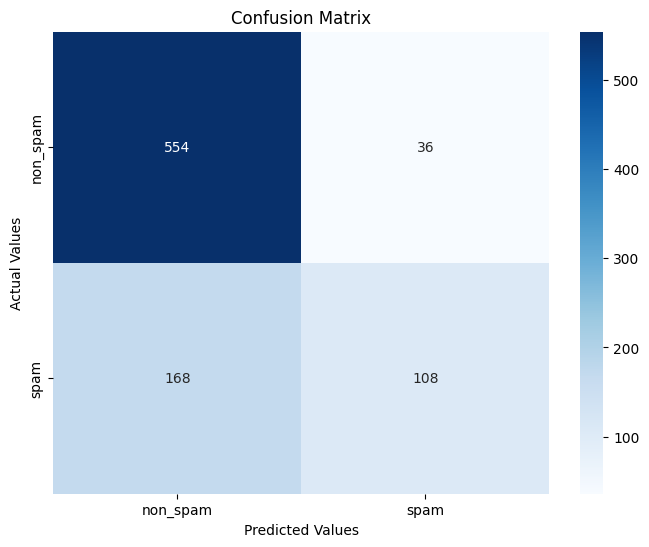

In [3]:
clf = NaiveBayesClassifier() # Create a Naive Bayes classifier
clf.fit(X_train_counts.toarray(), y_train) # Train the classifier (Multinomial Naive Bayes) using the training data and its labels

# Define the range of N values to analyze
N_values = [8, 16, 32, 64]

# Lists to store the number of false positives and true negatives for each N value
false_positives = []
true_negatives = []

# Iterate over each N value
for N in N_values:
    # Reduce the number of analyzed lexemes
    reduced_X_train_counts = X_train_counts[:, :N]
    reduced_X_test_counts = X_test_counts[:, :N]

    # Train the classifier with reduced feature vectors
    clf.fit(reduced_X_train_counts.toarray(), y_train)

    # Predict the labels for reduced feature vectors
    y_pred = clf.predict(reduced_X_test_counts.toarray(), print_results=False) 

    # Evaluate the classifier and store the number of false positives and true negatives
    cm = confusion_matrix(y_test, y_pred)
    false_positives.append(cm[0][1])
    true_negatives.append(cm[1][0])

# Plot the charts
plt.figure(figsize=(10, 6))

# Chart 1: Dependency of false positive number on N
plt.subplot(121)
plt.plot(N_values, false_positives, marker='o')
plt.title('Dependency of False Positive Number on N')
plt.xlabel('Number of Analyzed Lexemes (N)')
plt.ylabel('False Positive Number')

# Chart 2: Dependency of true negative number on N
plt.subplot(122)
plt.plot(N_values, true_negatives, marker='o')
plt.title('Dependency of True Negative Number on N')
plt.xlabel('Number of Analyzed Lexemes (N)')
plt.ylabel('True Negative Number')

plt.tight_layout()
plt.show()

'''
# Print X_train_counts and X_test_counts with explanation text
print("X_train_counts:")
print(X_train_counts)
print("X_test_counts:")
print(X_test_counts)
''' 
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Setting plot labels and titles
class_names = ['non_spam', 'spam']
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.xticks(ticks=np.arange(2) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(2) + 0.5, labels=class_names)

plt.show()

Dependency of false positive and true negative number on spamicity value of unseen lexeme

In [33]:
import pandas as pd

clf = NaiveBayesClassifier() # Create a Naive Bayes classifier
clf.fit(X_train_counts.toarray(), y_train) # Train the classifier using the training data and its labels

# This was for testing with all the test data
# Predict the labels for test data 
y2_pred = clf.predict(X_test_counts.toarray(), print_results=False)

# Evaluate the classifier
cm = confusion_matrix(y_test, y2_pred)
print("Confusion Matrix:")
print(cm)

# Ratio of correct predictions to the total number of predictions
accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate spamicity values for unseen lexemes
lexeme_spamicity = []
for lexeme in range(X_test_counts.shape[1]):
    spamicity = clf.feature_prob['spam'].get(lexeme, 0) / \
                (clf.feature_prob['spam'].get(lexeme, 0) + clf.feature_prob['non_spam'].get(lexeme, 0))
    lexeme_spamicity.append(spamicity)

# Sort lexemes by spamicity value
sorted_lexemes = sorted(zip(range(X_test_counts.shape[1]), lexeme_spamicity), key=lambda x: x[1])

# Prepare data for plotting
false_positives = []
true_negatives = []
spamicity_values = []

for lexeme, spamicity in sorted_lexemes:
    false_positives.append(cm[0][1])
    true_negatives.append(cm[1][0])
    spamicity_values.append(spamicity)
    
    # Set spamicity value for unseen lexeme
    clf.feature_prob['spam'][lexeme] = spamicity
    clf.feature_prob['non_spam'][lexeme] = 1 - spamicity

Shape of X: (3461, 81564)
Confusion Matrix:
[[588   2]
 [ 53 223]]
Accuracy: 93.65%


In [34]:
# Create a DataFrame with the collected data
data = pd.DataFrame({
    'Spamicity Value': spamicity_values,
    'False Positives': false_positives,
    'True Negatives': true_negatives
})

import openpyxl

# Save the DataFrame to an Excel file
data.to_excel('dependency_data.xlsx', index=False)

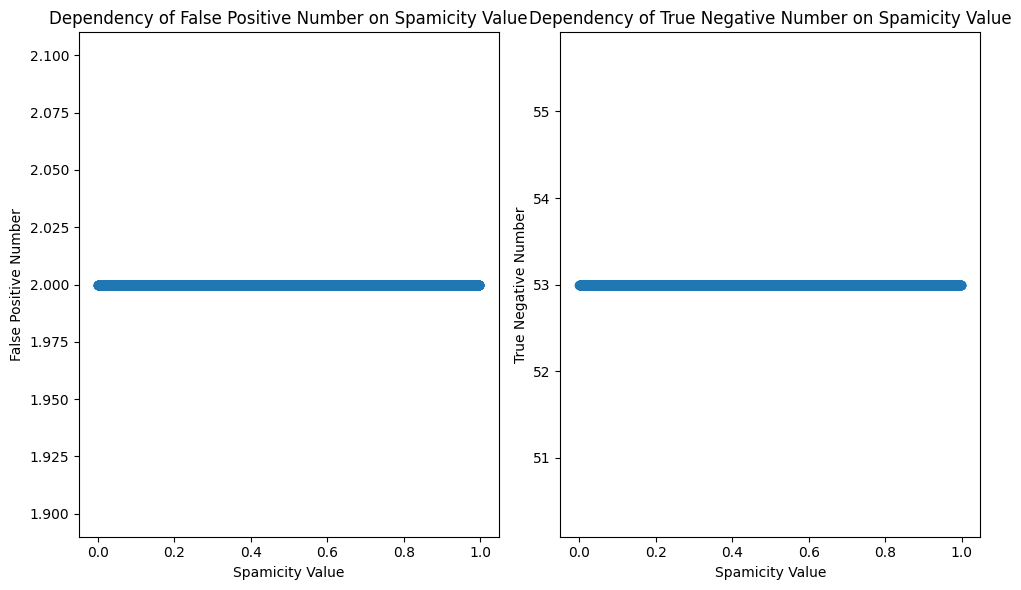

In [44]:
# Plot the dependency of false positive and true negative numbers on spamicity value of unseen lexemes
plt.figure(figsize=(10, 6))

# Chart 1: Dependency of false positive number on spamicity value
plt.subplot(121)
plt.plot(spamicity_values, false_positives, marker='o')
plt.title('Dependency of False Positive Number on Spamicity Value')
plt.xlabel('Spamicity Value')
plt.ylabel('False Positive Number')

# Chart 2: Dependency of true negative number on spamicity value
plt.subplot(122)
plt.plot(spamicity_values, true_negatives, marker='o')
plt.title('Dependency of True Negative Number on Spamicity Value')
plt.xlabel('Spamicity Value')
plt.ylabel('True Negative Number')

plt.tight_layout()
plt.show()

In [45]:
# Print false positive and true negative number
print("False Positive Number: ", cm[0][1])
print("True Negative Number: ", cm[1][0])

False Positive Number:  2
True Negative Number:  53
